In [11]:
# reload packages
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [13]:
import numpy as np
import pandas as pd

In [14]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

### load datasets

In [15]:
datasets = {}

##### FMNIST

In [16]:
from tensorflow.keras.datasets import fashion_mnist

# load dataset
(train_images, Y_train), (test_images, Y_test) = fashion_mnist.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

# subset a validation set
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

# flatten X
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
X_valid_flat= X_valid.reshape((len(X_valid), np.product(np.shape(X_valid)[1:])))
print(len(X_train), len(X_valid), len(X_test))

50000 10000 10000


In [17]:
datasets['fmnist'] = {'X':{}, 'Y':{}}
datasets['fmnist']['X']['train'] = X_train
datasets['fmnist']['X']['valid'] = X_valid
datasets['fmnist']['X']['test'] = X_test
datasets['fmnist']['Y']['train'] = Y_train
datasets['fmnist']['Y']['valid'] = Y_valid
datasets['fmnist']['Y']['test'] = Y_test

### Load projections

In [18]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [19]:
output_dir = MODEL_DIR/'projections'

In [45]:
classes = ['umap-learn', 'direct', 'network', 'autoencoder', 'parametric-tsne', 'TSNE', 'PCA']

In [46]:
dataset_list = ['fmnist']

In [47]:
projection_df = pd.DataFrame(columns = ['dataset', 'class_', 'train_z', 'train_label'])
for dataset in dataset_list:
    print(output_dir / dataset)
    for class_ in classes:
        print(output_dir / dataset / class_)
        z = np.load(output_dir / dataset / class_ / 'z.npy')
        projection_df.loc[len(projection_df)] = [dataset, class_, z, datasets[dataset]['Y']['train']]

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/fmnist
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/fmnist/umap-learn
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/fmnist/direct
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/fmnist/network
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/fmnist/autoencoder
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/fmnist/parametric-tsne
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/fmnist/TSNE
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/fmnist/PCA


In [48]:
projection_df[:3]

,dataset,class_,train_z,train_label
0,fmnist,umap-learn,"[[-0.87958676, 3.1754975], [14.624907, 4.74073...","[9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, ..."
1,fmnist,direct,"[[-9.001841, -1.2676237], [7.8440666, 0.585688...","[9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, ..."
2,fmnist,network,"[[-11.435405, 15.952625], [8.49006, -9.136711]...","[9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, ..."


### Plot projections

In [49]:
import matplotlib.pyplot as plt

In [50]:
from scipy.spatial import procrustes

### Procrustes alignment

In [51]:
dataset_subsets = {}

In [52]:
for dataset in dataset_list:
    dataset_subset = projection_df[projection_df.dataset == dataset]
    dataset_subset = dataset_subset.astype(object)
    z_umap_learn = dataset_subset[dataset_subset.class_ == 'umap-learn'].iloc[0]['train_z']
    unique_classes = [i for i in dataset_subset.class_.unique() if i != 'umap-learn']
    unique_classes
    dataset_subset['aligned'] = 0
    dataset_subset['aligned'] = dataset_subset['aligned'].astype(object)
    dataset_subset['disparity'] = 0
    umap_learn_row = np.where(dataset_subset.class_.values == 'umap-learn')[0][0]
    aligned_col = np.where(dataset_subset.columns == 'aligned')[0][0]
    for unique_class in unique_classes:
        class_row = np.where(dataset_subset.class_.values == unique_class)[0][0]
        z_umap_learn = dataset_subset.iloc[umap_learn_row].train_z
        z_umap = dataset_subset.iloc[class_row].train_z
        z_umaplearn_align, z_umap_align, disparity = procrustes(z_umap_learn, z_umap)
        dataset_subset.iloc[class_row,aligned_col] = [z_umap_align]
        dataset_subset.iloc[umap_learn_row,aligned_col] = [z_umaplearn_align]
    dataset_subsets[dataset] = dataset_subset

In [53]:
np.shape(z_umap_learn)

(50000, 2)

In [54]:
np.shape(z_umap)

(50000, 2)

In [55]:
dataset

'fmnist'

#### Plot dataset

In [56]:
dset_params = {

    'fmnist': {
        'cmap': plt.cm.tab10,
        's': 0.1,
        'alpha': 0.5,  
    },  
}

In [57]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR, FIGURE_DIR, save_fig

In [58]:
dataset = 'fmnist'

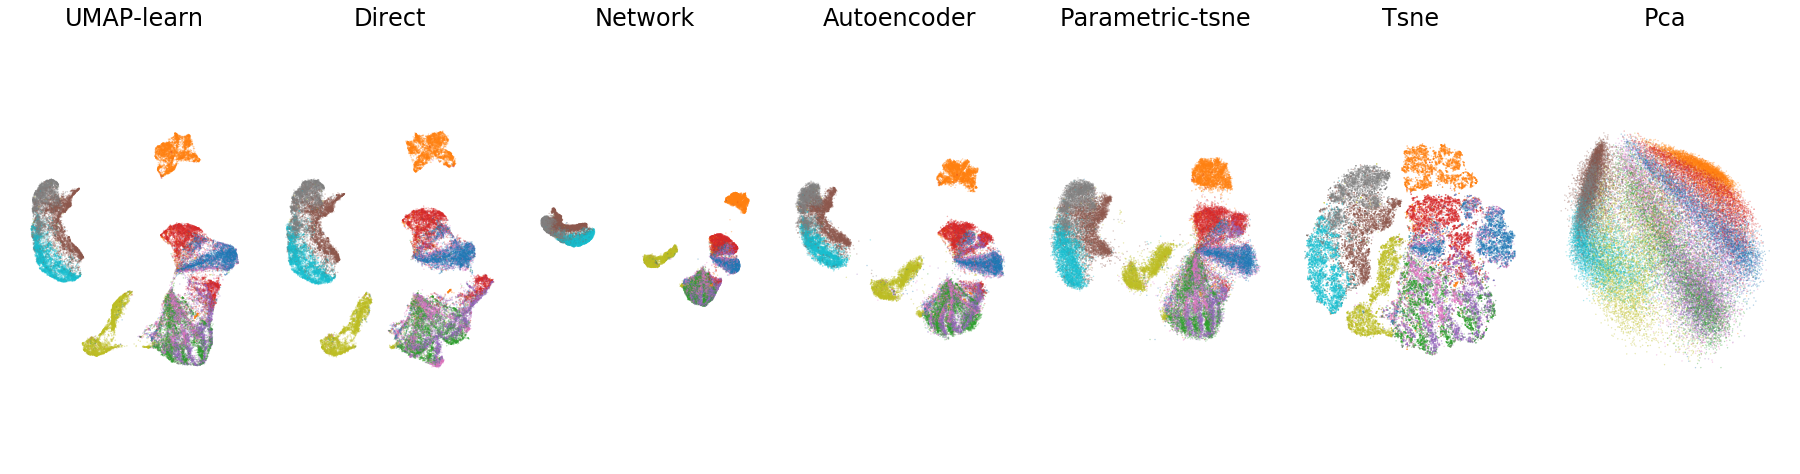

In [59]:
dataset_subset = dataset_subsets[dataset]
fig, axs = plt.subplots(ncols = len(unique_classes)+1, figsize = (32,8), gridspec_kw = {'wspace':0, 'hspace':0})
ax = axs[0]
z = dataset_subset.iloc[umap_learn_row].aligned
y = datasets[dataset]['Y']['train']
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=y,
    cmap=dset_params[dataset]['cmap'],
    s=dset_params[dataset]['s'],
    alpha=dset_params[dataset]['alpha'],
    rasterized=True,
)
ax.axis('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
ax.set_title('UMAP-learn', fontsize=24)
for i, unique_class in enumerate(unique_classes):
    ax = axs[i+1]
    class_row = np.where(dataset_subset.class_.values == unique_class)[0][0]
    z = dataset_subset.iloc[class_row].aligned
    sc = ax.scatter(
        z[:, 0],
        z[:, 1],
        c=y,
        cmap=dset_params[dataset]['cmap'],
        s=dset_params[dataset]['s'],
        alpha=dset_params[dataset]['alpha'],
    )
    ax.axis('equal')
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(unique_class.capitalize(), fontsize=24)

figdir = FIGURE_DIR / 'projections2d' / dataset
ensure_dir(figdir)
#save_fig(figdir, dpi = 300, save_png=True, pad_inches = 0.1) # save_pdf=True, 
plt.show()
#break

In [ ]:
# plot each individually

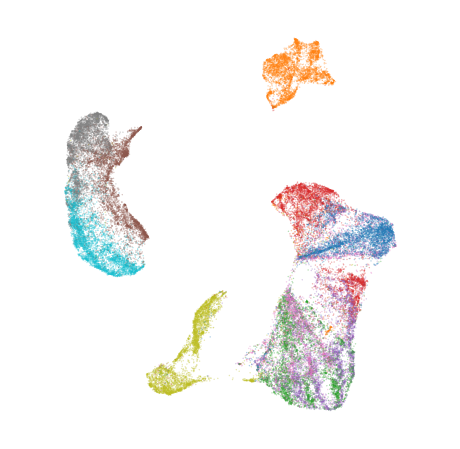

In [67]:
fig, ax = plt.subplots(figsize = (8,8), gridspec_kw = {'wspace':0, 'hspace':0})
z = dataset_subset.iloc[umap_learn_row].aligned
projection = 'umap_learn'
y = datasets[dataset]['Y']['train']
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=y,
    cmap=dset_params[dataset]['cmap'],
    s=dset_params[dataset]['s'],
    alpha=dset_params[dataset]['alpha'],
    rasterized=True,
)
ax.axis('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
figdir = FIGURE_DIR / 'fmnist_2d' / projection
ensure_dir(figdir)
save_fig(figdir, dpi = 300, save_png=True, pad_inches = 0.1) # save_pdf=True
#ax.set_title('UMAP-learn', fontsize=24)

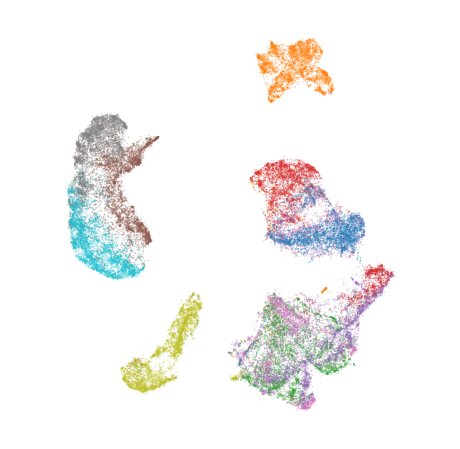

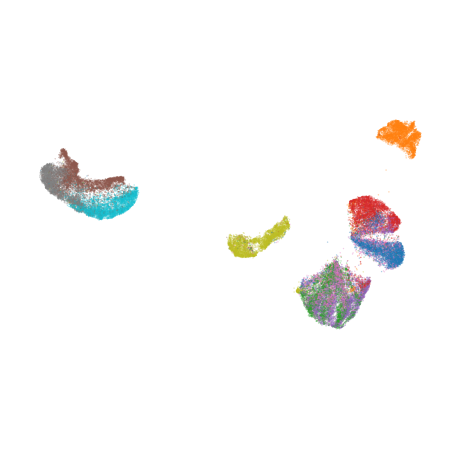

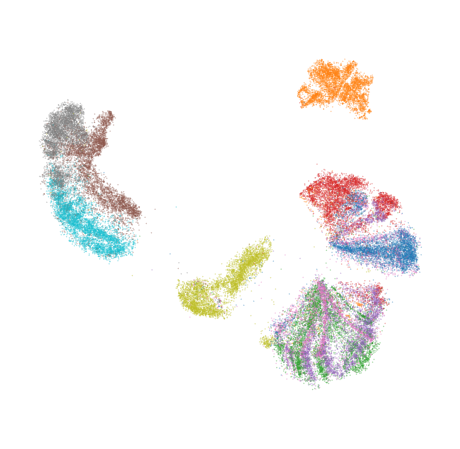

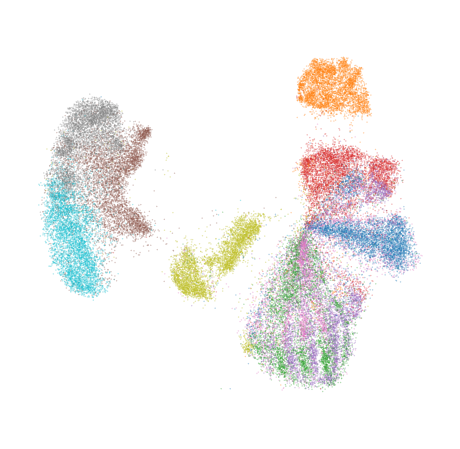

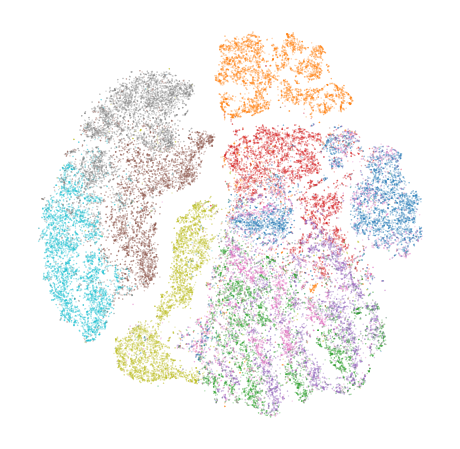

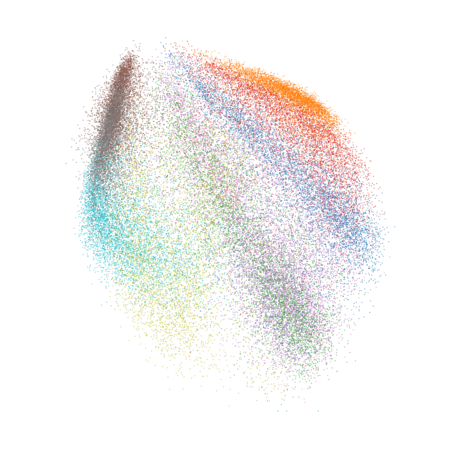

In [68]:
for i, unique_class in enumerate(unique_classes):
    fig, ax = plt.subplots(figsize = (8,8), gridspec_kw = {'wspace':0, 'hspace':0})
    class_row = np.where(dataset_subset.class_.values == unique_class)[0][0]
    projection = unique_class
    z = dataset_subset.iloc[class_row].aligned
    sc = ax.scatter(
        z[:, 0],
        z[:, 1],
        c=y,
        cmap=dset_params[dataset]['cmap'],
        s=dset_params[dataset]['s'],
        alpha=dset_params[dataset]['alpha'],
    )
    ax.axis('equal')
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_title(unique_class.capitalize(), fontsize=24)
    figdir = FIGURE_DIR / 'fmnist_2d' / projection
    ensure_dir(figdir)
    save_fig(figdir, dpi = 300, save_png=True, pad_inches = 0.1) # save_pdf=True
    plt.show()